## usar PyMC3 for density estimation and survival analysis
density estimation of antenna information like total_users etc.

**Obs:** Argentinean info is for one month only, Mexican data is the aggregation result of 5 months of analyisis

Based on the work of Austin Rochford

http://austinrochford.com/posts.html

In [2]:
server = True
if not(server):
    from matplotlib import pyplot as plt
    import seaborn as sns
    %matplotlib inline
    blue = sns.color_palette()[0]
    
import numpy as np
import pymc3 as pm
import scipy as sp
from statsmodels.datasets import get_rdataset
from theano import tensor as T

In [3]:
np.random.seed(462233) # from random.org
N = 20
K = 30

alpha = 2.
P0 = sp.stats.norm
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)

In [4]:
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
omega = P0.rvs(size=(N, K))
x_plot = np.linspace(-3, 3, 200)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

In [5]:
if not(server):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
            label='DP sample CDFs');
    ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
    ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

    ax.set_title(r'$\alpha = {}$'.format(alpha));
    ax.legend(loc=2);

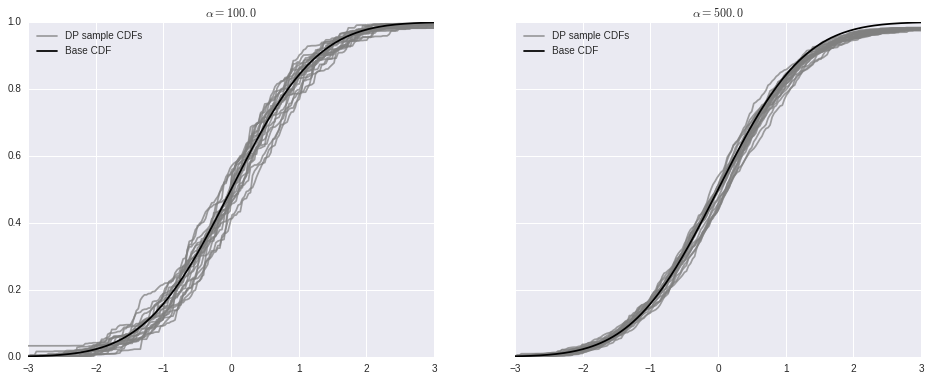

In [63]:
if not(server):
    fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 500
alpha = 100.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)
if not(server):
    l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
              label='DP sample CDFs');
    l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
    l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

    l_ax.set_title(r'$\alpha = {}$'.format(alpha));
    l_ax.legend(loc=2);

K = 2000
alpha = 500.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)
if not(server):
    r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
              label='DP sample CDFs');
    r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
    r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

    r_ax.set_title(r'$\alpha = {}$'.format(alpha));
    r_ax.legend(loc=2);

## Comparing Mexican/Argentinean cellphone usage at an antenna level
Antenna data usage from mexico vs. argentina

**Obs:** Argentinean info is for one month only, Mexican data is the aggregation result of 5 months of analyisis

## Differences
* Mexican data is aggregated on a five month period vs Argentina one-per month

In [13]:
import pandas as pd
pd.set_option('display.max_rows', 300)
from IPython.display import Image
import unicodedata
import os
import random
import time

np.random.seed(2016)

In [16]:
!ls /home/juan/mobility-study/data/

mexico_ant2vuln_aggregation.txt


In [17]:
arg_ant = "/gran_chaco_201201_in.csv"
arg_file = "/home/juan/mobility-study/argentina-scripts/data/users_per_antenna/calls" +arg_ant
mex_file = "/home/juan/mobility-study/data/mexico_ant2vuln_aggregation.txt"

table_arg  = pd.read_csv(arg_file,
                engine = 'c',
                sep = '|',
                header = 0,
                index_col=0,
                usecols = ['antenna','users','vuln_users','calls','vuln_calls']
            )


#dropeamos la antenna 0 y la 2 que son las antenas "basura" en esta tabla

#table_arg.drop(0,inplace=True)
#table_arg.drop(2,inplace=True)


table_mex = pd.read_csv(mex_file,
                engine = 'c',
                sep = '|',
                header = 0,
                index_col=0,
                usecols = ['ANTENNA_ID_0','TOTAL_USERS','EPI_USERS','TOTAL_Calls','TOTAL_EPI_Calls']
                )
#renombro por consistencia con la otra tabla
table_mex.index.name = 'antenna'
table_mex.columns = ['users','vuln_users','calls','vuln_calls']

In [18]:
table_arg.head()

,users,vuln_users,calls,vuln_calls
antenna,,,,
0,1157574,178565,0,0
2,3362252,212841,39056005,441263
3,2967,130,71976,716
4,11339,10704,453850,421447
5,8685,167,445487,508


In [19]:
#este cuantil me va a filtrar algunas antenas "outliers" de uso "excesivo"
quant =0.99
total_users_arg = table_arg['users'].sum()
total_users_mex = table_mex['users'].sum()
total_calls_arg = table_arg['calls'].sum()
total_calls_mex = table_mex['calls'].sum()

In [20]:
print("""Total TelCo users in Argentina: {0}\n
Total TelCo users in Mexico:{1}\n
Total TelCo calls for one month in Argentina:{2}\n
Total TelCo calls for five month in Mexico:{3}\n""".format(total_users_arg,
                                                     total_users_mex,
                                                     total_calls_arg,
                                                     total_calls_mex))

Total TelCo users in Argentina: 23965662

Total TelCo users in Mexico:2449242

Total TelCo calls for one month in Argentina:696840521

Total TelCo calls for five month in Mexico:94113889



In [22]:
col = 'users'

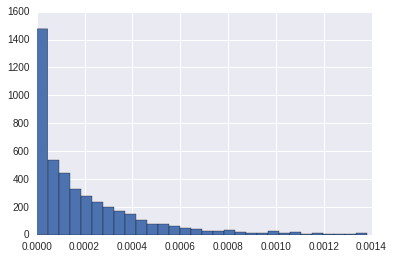

In [77]:
(table_arg[table_arg[col] < table_arg[col].quantile(quant)][col]/total_users_arg).hist(bins=30)

In [23]:

old_faithful_df = table_arg[table_arg[col] < table_arg[col].quantile(quant)][col].to_frame()
old_faithful_df.columns = ['users']

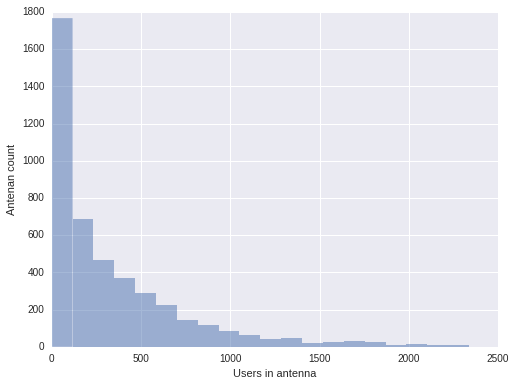

In [93]:
if not(server):
    fig, ax = plt.subplots(figsize=(8, 6))

    n_bins = 20
    ax.hist(old_faithful_df.users, bins=n_bins, color=blue, lw=0, alpha=0.5);

    ax.set_xlabel('Users in antenna');
    ax.set_ylabel('Antenan count');

In [25]:
%%time
N = old_faithful_df.shape[0]

K = 100

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))
    component = pm.Categorical('component', w, shape=N)

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, lambda_ * tau, shape=K)
    obs = pm.Normal('obs', mu[component], lambda_[component] * tau[component],
                    observed=old_faithful_df.users.values)



Applied log-transform to alpha and added transformed alpha_log to model.
Applied logodds-transform to beta and added transformed beta_logodds to model.
Applied log-transform to tau and added transformed tau_log to model.
Applied interval-transform to lambda and added transformed lambda_interval to model.
CPU times: user 548 ms, sys: 12 ms, total: 560 ms
Wall time: 554 ms


In [27]:
%%time

with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, lambda_, tau, mu, obs])
    if not(server):
        step2 = pm.ElemwiseCategorical([component], np.arange(K))
    else:
        step2 = pm.ElemwiseCategoricalStep([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2],njobs=8)

trace = trace_[10000::10]

 [-----------------100%-----------------] 20000 of 20000 complete in 6562.7 secCPU times: user 50.7 s, sys: 22.2 s, total: 1min 12s
Wall time: 1h 50min 10s


In [28]:
if not(server):
    pm.traceplot(trace, varnames=['alpha']);

n_components_used = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])

In [ ]:
if not(server):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = np.arange(n_components_used.min(), n_components_used.max() + 1)
    ax.hist(n_components_used + 1, bins=bins, normed=True, lw=0, alpha=0.75);

    ax.set_xticks(bins + 0.5);
    ax.set_xticklabels(bins);
    ax.set_xlim(bins.min(), bins.max() + 1);
    ax.set_xlabel('Number of mixture components used');

    ax.set_ylabel('Posterior probability');

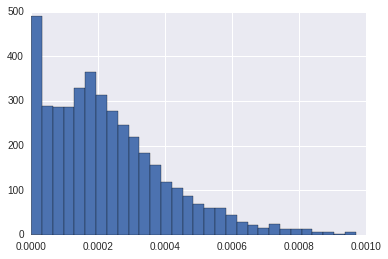

In [78]:
(table_mex[table_mex[col] < table_mex[col].quantile(quant)][col]/total_users_mex).hist(bins=30)

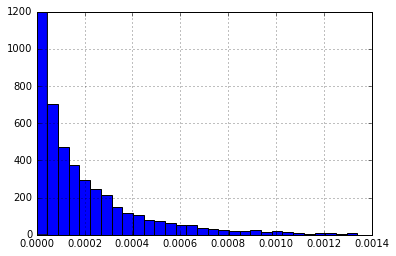

In [93]:
col = 'calls'
(table_arg[table_arg[col] < table_arg[col].quantile(quant)][col]/total_calls_arg).hist(bins=30)

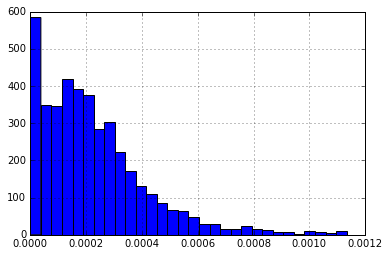

In [94]:
(table_mex[table_mex[col] < table_mex[col].quantile(quant)][col]/total_calls_mex).hist(bins=30)

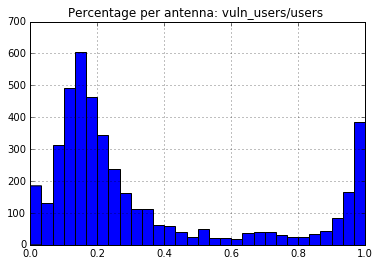

In [95]:
col = 'users'
vuln_col = "vuln_"+col
a = table_arg[table_arg[col] < table_arg[col].quantile(quant)][col]
b = table_arg[table_arg[vuln_col] < table_arg[col].quantile(quant)][vuln_col]
(1-((a-b)/a)).hist(bins=30)
plt.title("Percentage per antenna: {1}/{0} ".format(col,vuln_col))

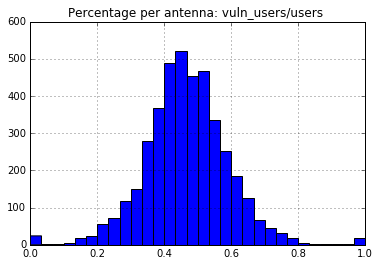

In [15]:
a = table_mex[table_mex[col] < table_mex[col].quantile(quant)][col]
b = table_mex[table_mex[vuln_col] < table_mex[col].quantile(quant)][vuln_col]
(1-((a-b)/a)).hist(bins=30)
plt.title("Percentage per antenna: {1}/{0} ".format(col,vuln_col))

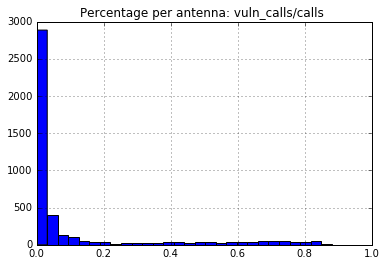

In [16]:
col = 'calls'
vuln_col = "vuln_"+col
a = table_arg[table_arg[col] < table_arg[col].quantile(quant)][col]
b = table_arg[table_arg[vuln_col] < table_arg[col].quantile(quant)][vuln_col]
(1-((a-b)/a)).hist(bins=30)
plt.title("Percentage per antenna: {1}/{0} ".format(col,vuln_col))

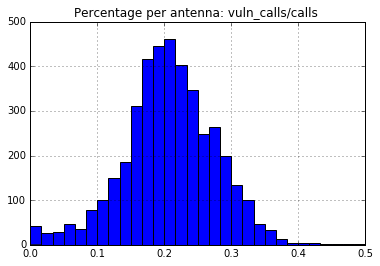

In [17]:
a = table_mex[table_mex[col] < table_mex[col].quantile(quant)][col]
b = table_mex[table_mex[vuln_col] < table_mex[col].quantile(quant)][vuln_col]
(1-((a-b)/a)).hist(bins=30)
plt.title("Percentage per antenna: {1}/{0} ".format(col,vuln_col))

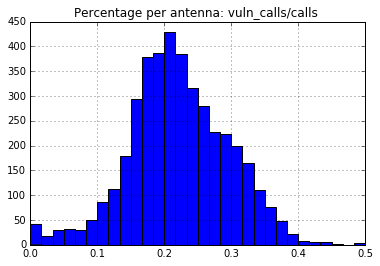

In [22]:
a = table_mex[table_mex[col] < table_mex[col].quantile(quant)][col]
b = table_mex[table_mex[vuln_col] < table_mex[col].quantile(quant)][vuln_col]
(1-((a-b)/a)).hist(bins=30)
plt.title("Percentage per antenna: {1}/{0} ".format(col,vuln_col))

In [102]:
print("Descriptive statistics per antenna for the Argentinian Dataset\n")
for col in table_arg.columns:
    print("For column '{0}':\n{1}\n".format(col,table_arg[col].describe()))

Descriptive statistics per antenna for the Argentinian Dataset

For column 'users':
count     4507.00000
mean       375.94675
std        576.34156
min          0.00000
25%         47.00000
50%        198.00000
75%        501.00000
max      13500.00000
Name: users, dtype: float64

For column 'vuln_users':
count    4507.000000
mean      124.501442
std       247.962259
min         0.000000
25%        11.000000
50%        41.000000
75%       115.000000
max      3091.000000
Name: vuln_users, dtype: float64

For column 'calls':
count      4507.000000
mean      53447.879521
std       70234.638226
min           0.000000
25%        9828.000000
50%       29589.000000
75%       69629.000000
max      931363.000000
Name: calls, dtype: float64

For column 'vuln_calls':
count      4507.000000
mean       6242.291546
std       19695.709108
min           0.000000
25%         180.500000
50%         593.000000
75%        2196.500000
max      301997.000000
Name: vuln_calls, dtype: float64



In [103]:
print("Descriptive statistics per antenna for the Mexican Dataset\n")
for col in table_arg.columns:
    print("For column '{0}':\n{1}\n".format(col,table_mex[col].describe()))

Descriptive statistics per antenna for the Mexican Dataset

For column 'users':
count    4178.000000
mean      586.223552
std       501.208718
min         1.000000
25%       234.000000
50%       483.000000
75%       802.000000
max      4737.000000
Name: users, dtype: float64

For column 'vuln_users':
count    4178.000000
mean      295.374342
std       306.059165
min         0.000000
25%       100.250000
50%       226.000000
75%       395.000000
max      3629.000000
Name: vuln_users, dtype: float64

For column 'calls':
count      4178.000000
mean      22526.062470
std       22400.606131
min           2.000000
25%        8327.500000
50%       17788.500000
75%       29603.500000
max      285062.000000
Name: calls, dtype: float64

For column 'vuln_calls':
count     4178.000000
mean      5079.277884
std       6012.525971
min          0.000000
25%       1510.000000
50%       3630.000000
75%       6491.750000
max      73007.000000
Name: vuln_calls, dtype: float64



## Hist Result
A la vista, tenemos el doble de usuarios en la telco argentina que en la mejicana

Tambien sucede que al comparar los histogramas de "porcentajes" de usuarios/calls vulnerable a nivel antenna, vemos patrones muy distintos de comportamiento. Con una separacion importante en la argentina y una distribucion mas "normal" en mexico.

**Obs:** el resultado es el mismo si se prueba con otros meses para el dataset argentino
